In [100]:
import DeconV as dv

import torch
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
# Download data from: https://xuranw.github.io/MuSiC/articles/pages/data.html
# ExpressionSet: 'XinT2Deset.rds' (Single cell RNA-seq data of pancreatic islet from healthy and diseased individuals(Xin et al.))
# ExpressionSet: 'EMTABesethealthy.rds' (Single cell RNA-seq data of pancreatic islets from healthy individuals (Segerstolpe et al.))
# Use the rds_to_csv.r script to convert to csv

reference_file = "../../data/xin/sc.txt"
reference_mdata_file = "../../data/xin/pdata.txt"
bulk_file = "../../data/xin/bulk.txt"
cell_types = ["alpha", "delta", "gamma", "beta"]

sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white')
sc.settings.figdir = "../deconV/figures/"

### 1. Read data + basic QC

In [102]:
adata = sc.read_csv(reference_file, first_column_names=True, delimiter="\t")

pheno_df = pd.read_table(reference_mdata_file, index_col=0)
pheno_df.index.name = None
common_cells = list(set(pheno_df.index.tolist()) & set(adata.obs_names.tolist()))


adata = adata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
adata.obs["labels"] = pheno_df["cellType"].tolist()
adata.obs["labels"] = adata.obs["labels"].astype("category")

adata = adata[adata.obs["labels"].astype("str").isin(cell_types), :].copy()

print(adata.obs.groupby("labels").size())

bulk_df = pd.read_table(bulk_file, index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_counts=100)

labels
alpha    443
beta     171
delta     59
gamma     75
dtype: int64
bulk RNA-seq data - samples: 18, genes: 39849


In [103]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2. Initialize model

In [104]:
decon = dv.DeconV(
    adata,
    bulk=bulk_df,
    cell_type_key="labels",         # cell_type_key is the column key in adata.obs that holds the cell type annotations 
    dropout_type="separate",        # separate, shared, or None
    model_type="gamma",             # Gamma, Beta, nb, lognormal, or static    
    device=device,
    layer=None,
    top_n_variable_genes=10000,
)

Using 10000 common genes between the reference and the bulk data.
Rounding counts to integers.


### 3. Train the reference model

In [105]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:30<00:00, 66.54it/s, loss=2.56e+05, lr=1.35e-02]


### 4. Deconvolute

In [106]:
proportions = decon.deconvolute(model_dropout=True, lrd=0.999, lr=0.1, num_epochs=1000)
proportions

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 173.24it/s, loss=4.70e+08, lr=3.68e-02]


,alpha,beta,delta,gamma
Non T2D 1,0.508057,0.367673,0.045822,0.078448
Non T2D 2,0.120937,0.642695,0.031158,0.205210
Non T2D 3,0.722642,0.154239,0.059125,0.063994
Non T2D 5,0.511635,0.338278,0.087073,0.063014
Non T2D 6,0.851688,0.075231,0.071585,0.001496
Non T2D 7,0.327468,0.452091,0.000001,0.220440
Non T2D 8,0.334094,0.351548,0.109526,0.204832
Non T2D 9,0.661556,0.154696,0.003762,0.179986
Non T2D 10,0.549206,0.401937,0.048398,0.000458
Non T2D 11,0.623574,0.300135,0.015186,0.061105


### Visualize results

In [107]:
df = decon.get_results_df()
df

,sample,cell_type,est,min,max
0,Non T2D 1,alpha,0.508057,0.052163,0.054225
1,Non T2D 2,alpha,0.120937,0.033071,0.038485
2,Non T2D 3,alpha,0.722642,0.041145,0.039842
3,Non T2D 5,alpha,0.511635,0.065292,0.066329
4,Non T2D 6,alpha,0.851688,0.043720,0.039510
...,...,...,...,...,...
67,T2D 3,gamma,0.131817,0.033094,0.037288
68,T2D 1,gamma,0.413428,0.049145,0.049395
69,T2D 4,gamma,0.013057,0.009640,0.016142
70,T2D 5,gamma,0.002145,0.001994,0.004464


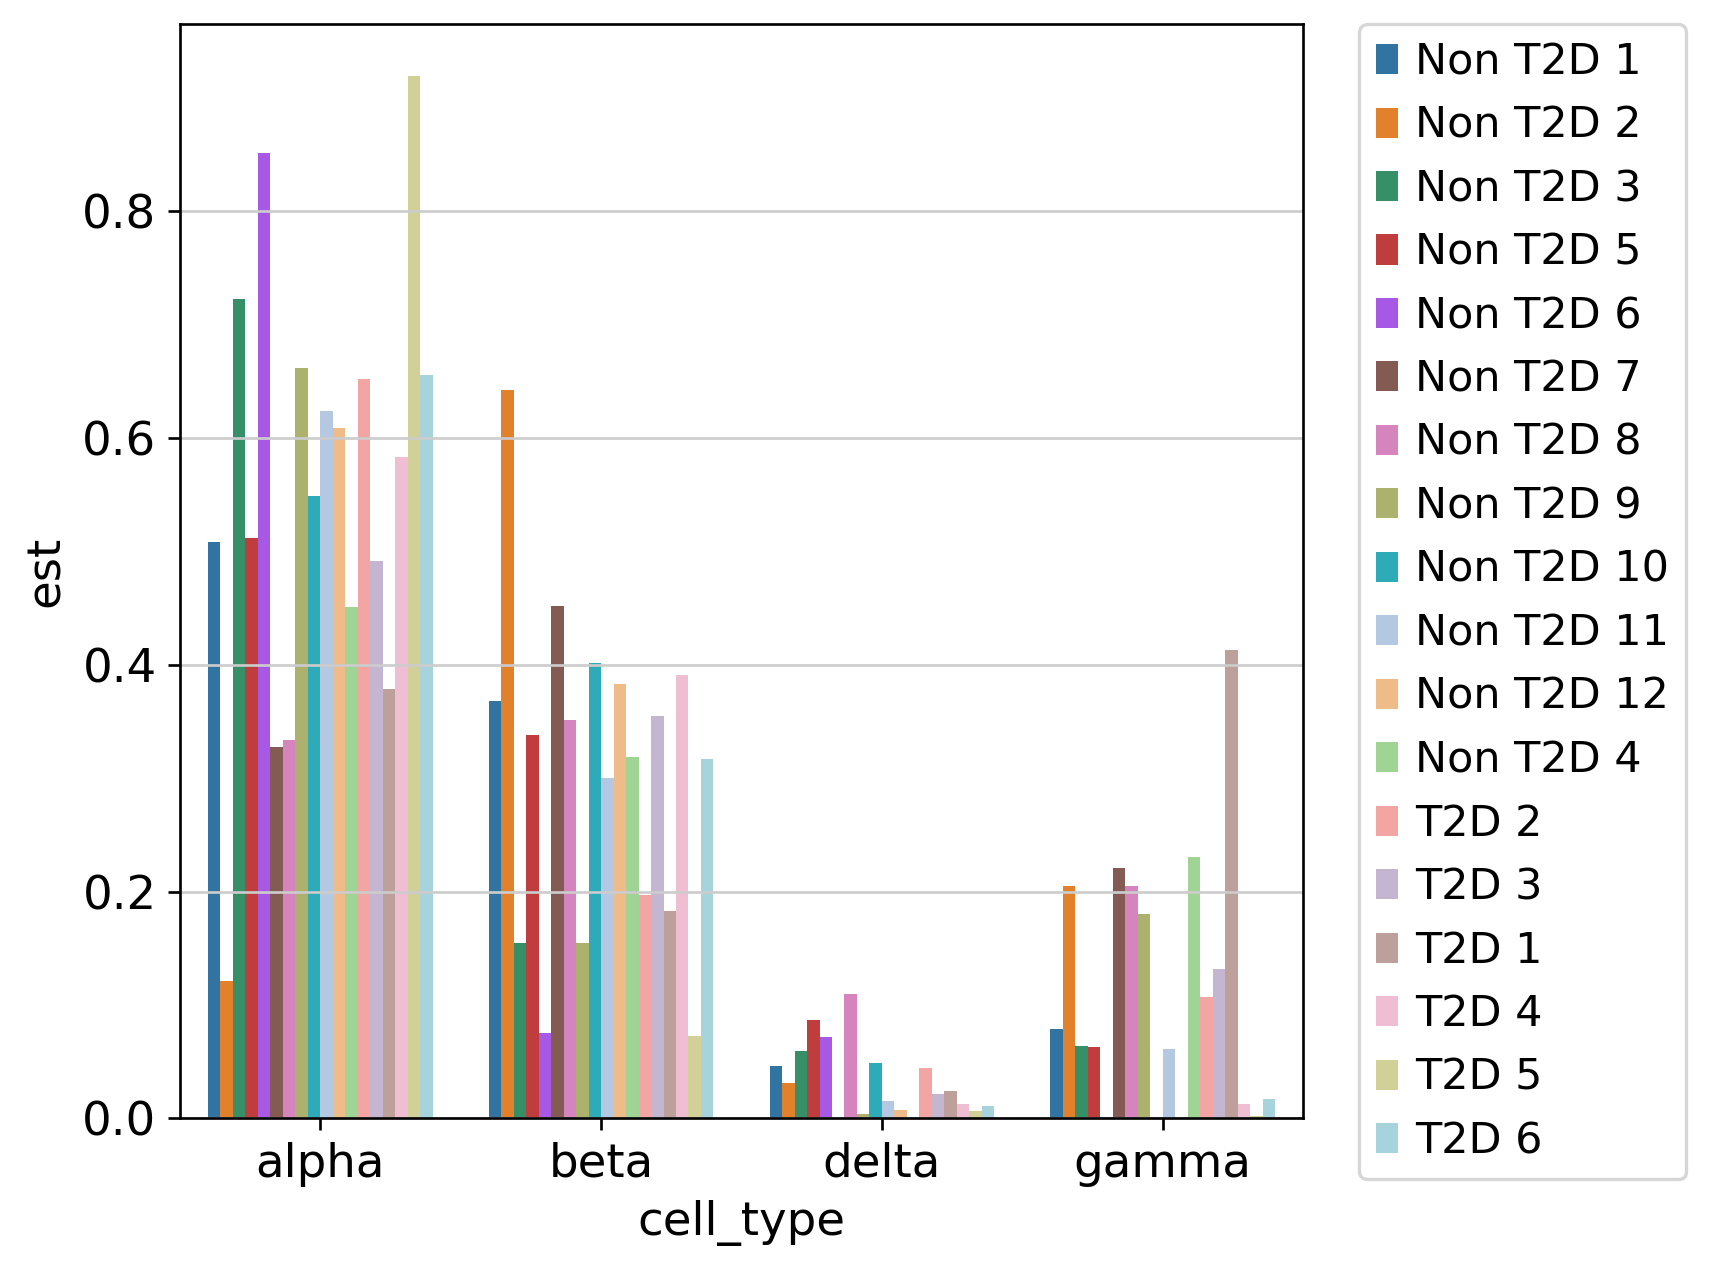

In [108]:
f, ax = plt.subplots(figsize=(6,6), dpi=120)

sns.barplot(
    data=df, x="cell_type", y="est", hue="sample", ax=ax
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<AxesSubplot: xlabel='cell_type', ylabel='est'>

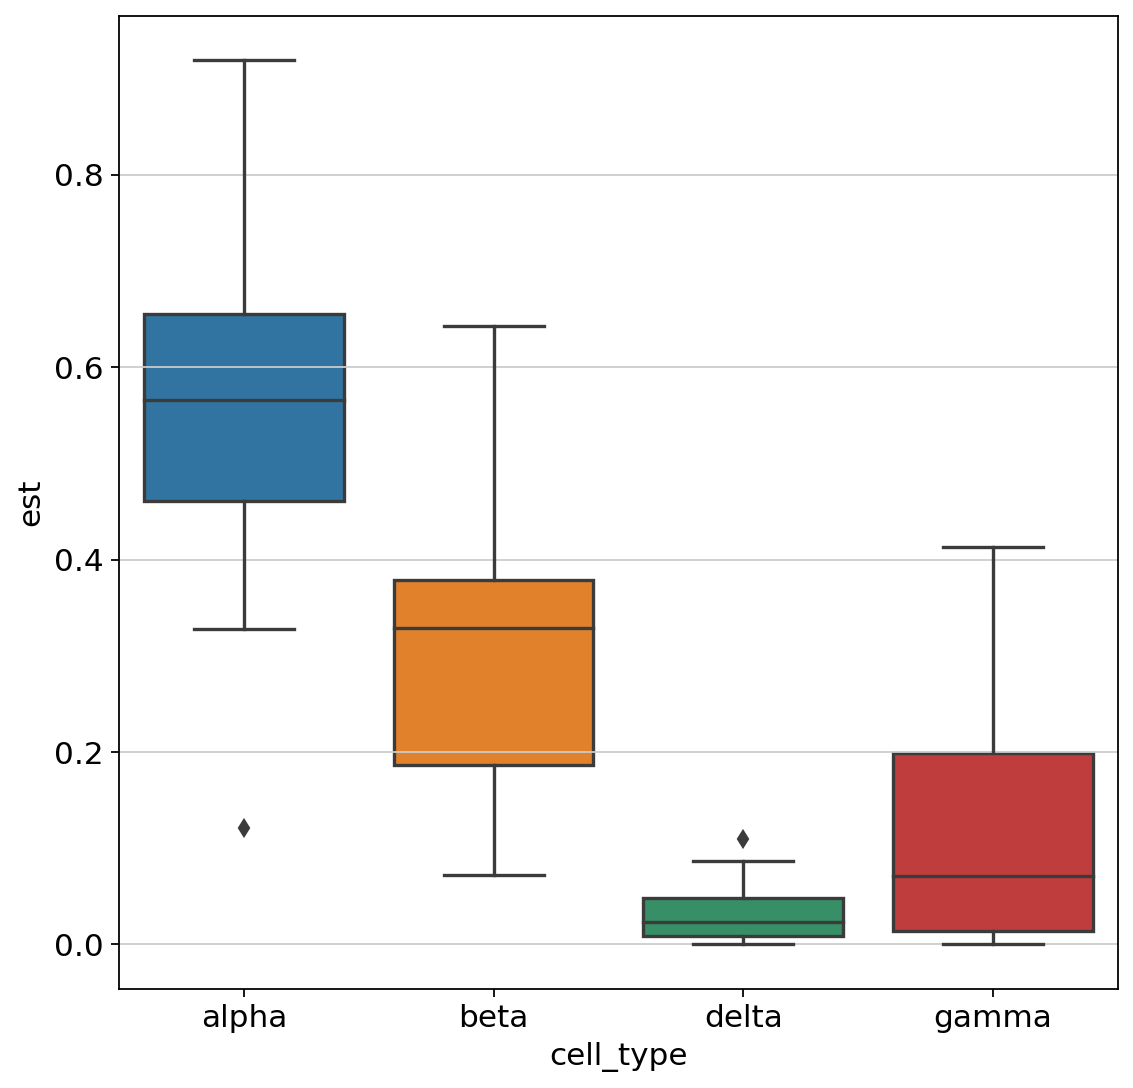

In [109]:
# Summarize proportions with boxplot
sns.boxplot(
    data=df, x="cell_type", y="est"
)

In [110]:
df

,sample,cell_type,est,min,max
0,Non T2D 1,alpha,0.508057,0.052163,0.054225
1,Non T2D 2,alpha,0.120937,0.033071,0.038485
2,Non T2D 3,alpha,0.722642,0.041145,0.039842
3,Non T2D 5,alpha,0.511635,0.065292,0.066329
4,Non T2D 6,alpha,0.851688,0.043720,0.039510
...,...,...,...,...,...
67,T2D 3,gamma,0.131817,0.033094,0.037288
68,T2D 1,gamma,0.413428,0.049145,0.049395
69,T2D 4,gamma,0.013057,0.009640,0.016142
70,T2D 5,gamma,0.002145,0.001994,0.004464


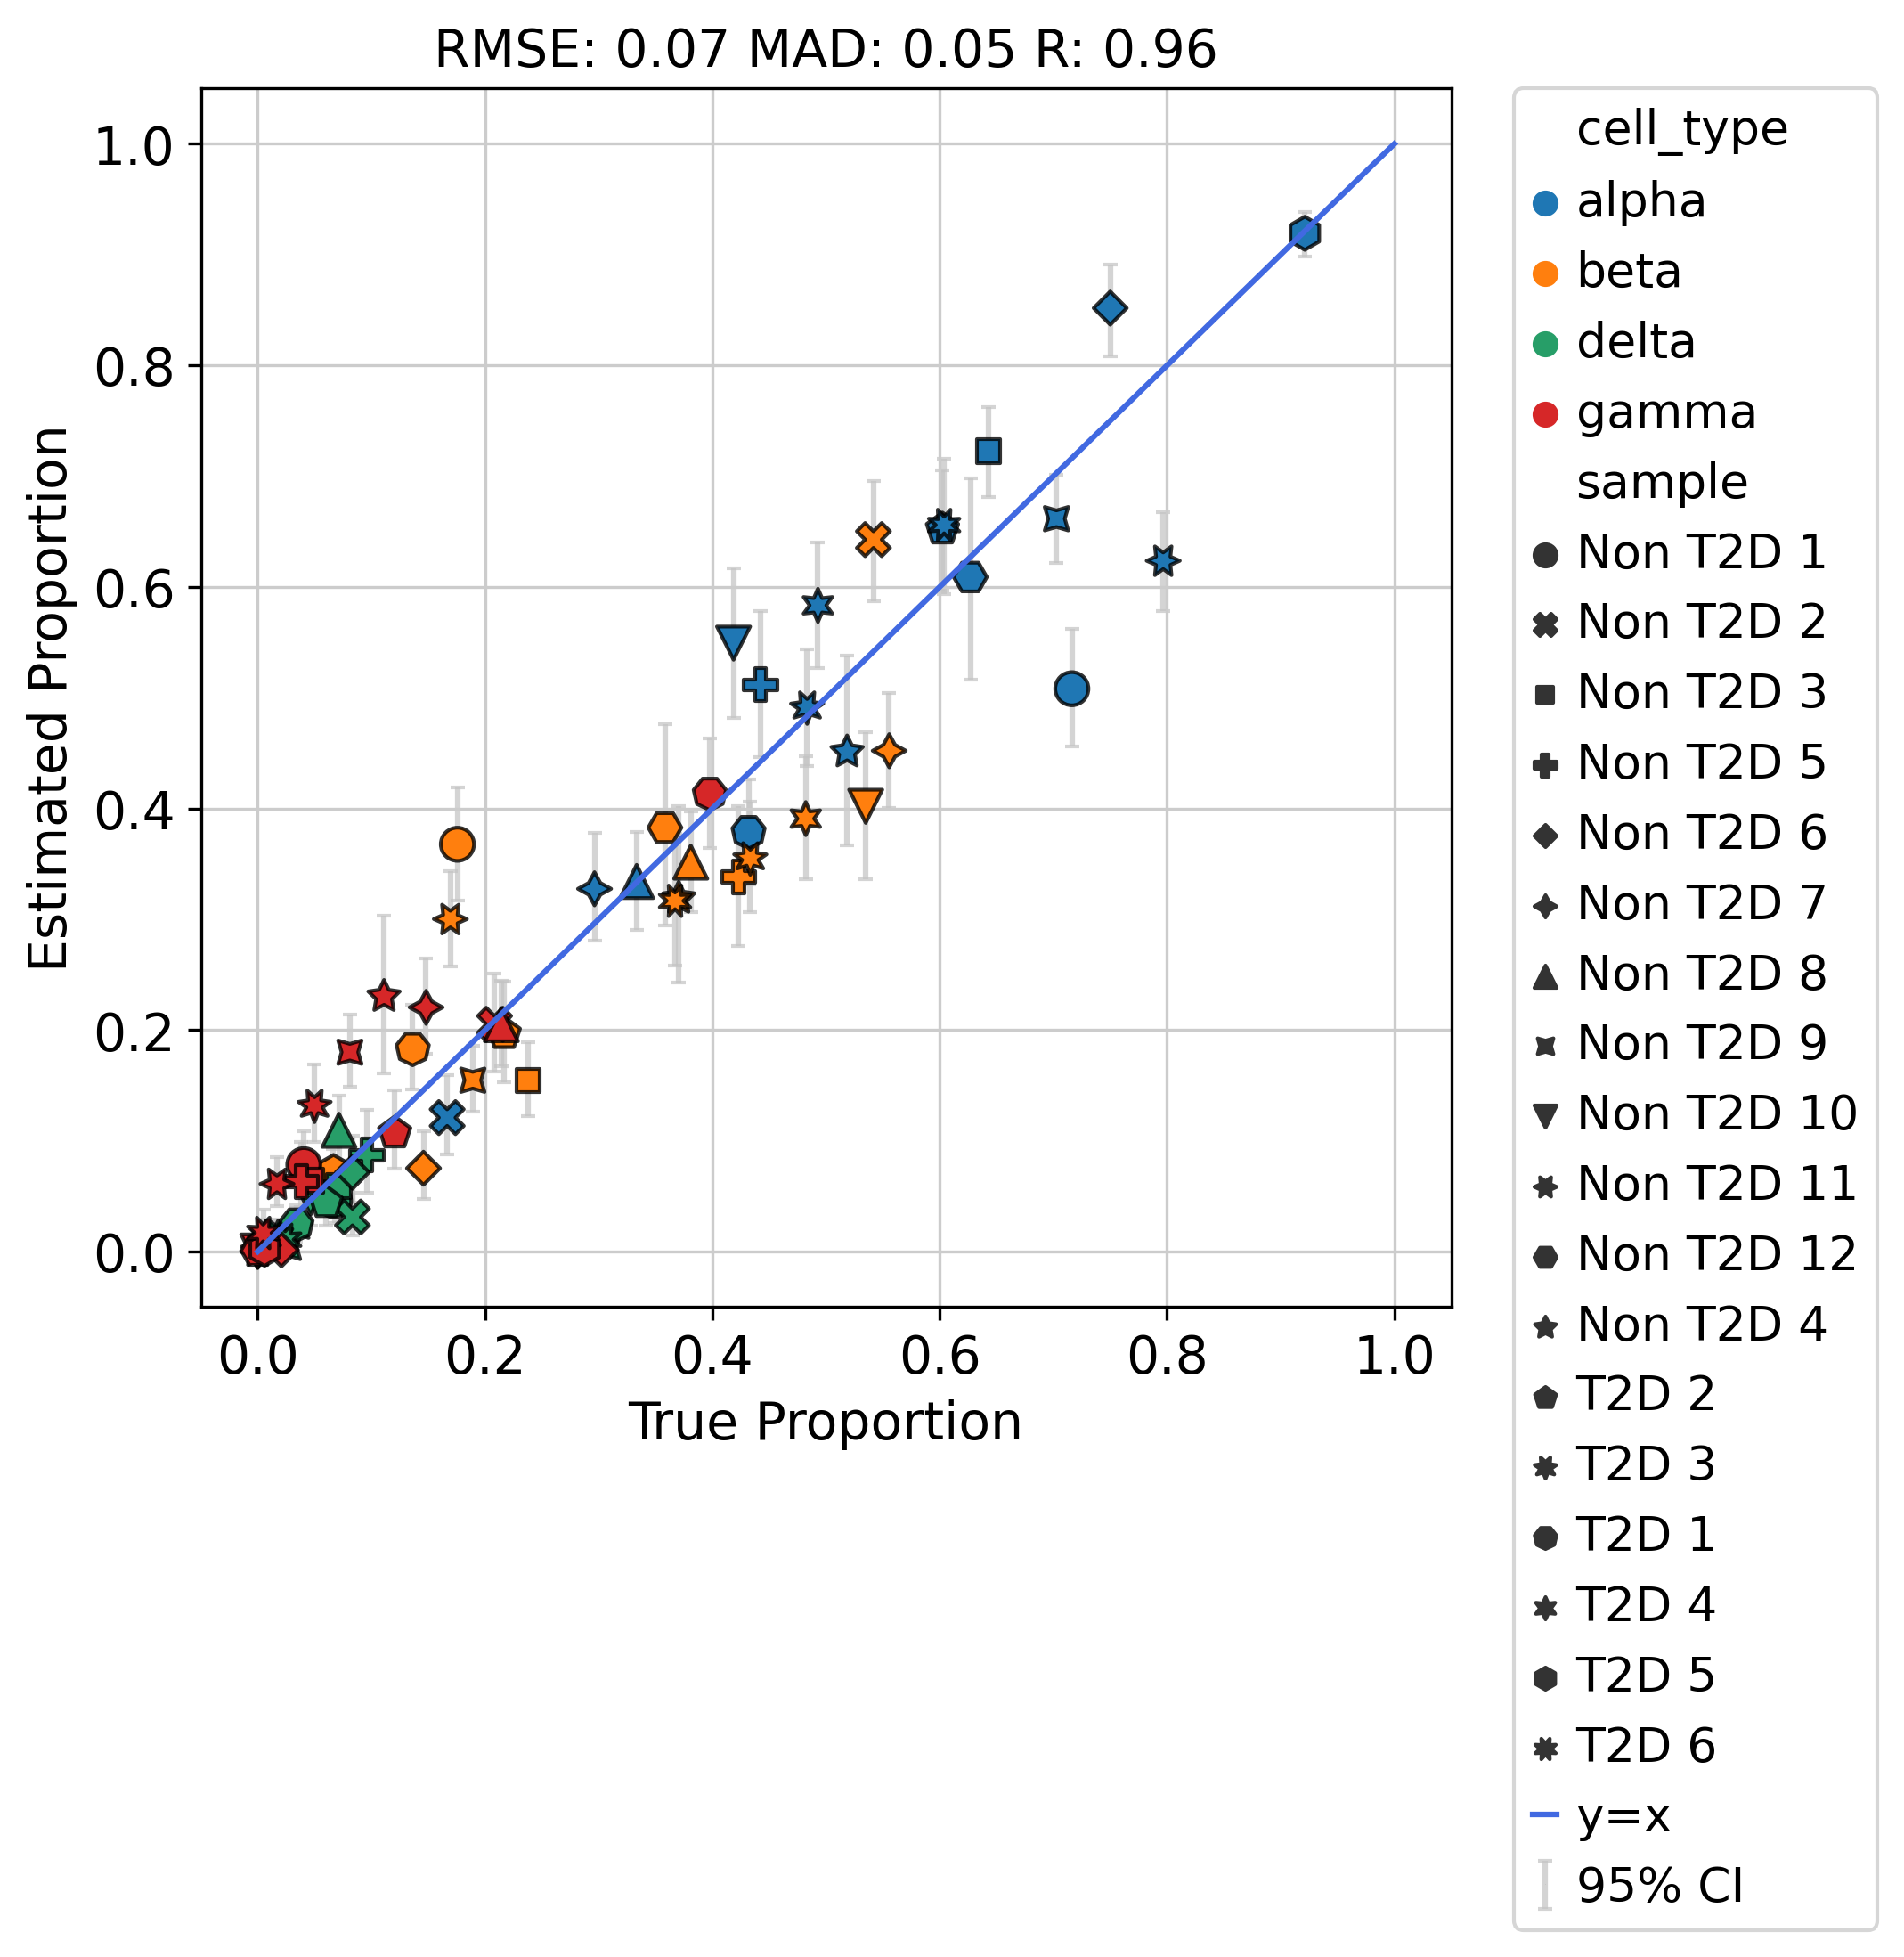

(0.06687049439140574, 0.04679542213231199, 0.9616146041207344)

In [111]:
# Ground truth proportions
true_df = pd.read_table("../../data/xin/proportions.txt", index_col=0)

df["true"] = df.apply(lambda row: true_df.loc[row["sample"], row["cell_type"]], axis=1)

dv.pl.xypredictions(df, figsize=(6,6), dpi=150)